In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [3]:
# Constants
NUM_CLASSES = 10
IMAGE_SIZE = (128, 128)  # Use smaller images
BATCH_SIZE = 32  # Increase batch size if possible
EPOCHS = 50  # Train for more epochs

In [4]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

In [5]:
# --- Make tf.data.Dataset that resizes on the fly ---
def preprocess(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.map(preprocess)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
# --- Build the Model ---
base_model = EfficientNetV2B0(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Initially freeze the base model

inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(NUM_CLASSES)(x)
outputs = layers.Activation('softmax')(x)

model = models.Model(inputs, outputs)

In [7]:
# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# --- Callbacks ---
# Learning rate scheduler to reduce LR when validation loss plateaus
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    min_lr=1e-6,
    verbose=1
)

# Early stopping to stop training if validation accuracy doesn't improve
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,085,082 (23.21 MB)

 Trainable params: 165,514 (646.54 KB)

 Non-trainable params: 5,919,568 (22.58 MB)

In [8]:
# --- Train ---
model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[lr_callback, early_stop]
)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.1195 - loss: 2.5426 - val_accuracy: 0.1000 - val_loss: 2.7285 - learning_rate: 5.0000e-04
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.1497 - loss: 2.2737 - val_accuracy: 0.1318 - val_loss: 3.0221 - learning_rate: 5.0000e-04
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.1740 - loss: 2.1976 - val_accuracy: 0.1043 - val_loss: 2.5907 - learning_rate: 5.0000e-04
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.1908 - loss: 2.1597 - val_accuracy: 0.1250 - val_loss: 2.7746 - learning_rate: 5.0000e-04
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.1929 - loss: 2.1411 - val_accuracy: 0.1432 - val_loss: 2.3066 - learning_rate: 5.0000e-04
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.2018 - loss: 2.1248 - val_accuracy: 0.1275 - val_loss: 2.8532 - learning_rate: 5.0000e-04
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━

In [9]:
# --- Unfreeze some layers and fine-tune ---
base_model.trainable = True  # Unfreeze the base model
# Recompile with lower learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Fine-tune for more epochs
model.fit(
    train_dataset,
    epochs=20,  # Additional fine-tuning epochs
    validation_data=val_dataset,
    callbacks=[lr_callback, early_stop]
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 222s 87ms/step - accuracy: 0.2124 - loss: 2.2177 - val_accuracy: 0.3361 - val_loss: 1.6342 - learning_rate: 1.0000e-05
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 87s 55ms/step - accuracy: 0.3463 - loss: 1.6598 - val_accuracy: 0.4381 - val_loss: 1.4635 - learning_rate: 1.0000e-05
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 56ms/step - accuracy: 0.4367 - loss: 1.5025 - val_accuracy: 0.5416 - val_loss: 1.3062 - learning_rate: 1.0000e-05
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 140s 55ms/step - accuracy: 0.5230 - loss: 1.3420 - val_accuracy: 0.6283 - val_loss: 1.1441 - learning_rate: 1.0000e-05
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step - accuracy: 0.6069 - loss: 1.1880 - val_accuracy: 0.7115 - val_loss: 0.9841 - learning_rate: 1.0000e-05
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step - accuracy: 0.6793 - loss: 1.0393 - val_accuracy: 0.7663 - val_loss: 0.8561 - learning_rate: 1.0000e-05
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━

In [11]:
# --- Evaluate ---
test_loss, test_acc = model.evaluate(val_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9353 - loss: 0.2154
Test Accuracy: 0.9357


In [12]:
# --- Prediction & Visualization ---
CLASSES = np.array([
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
])

predictions = model.predict(val_dataset)
predicted_classes = CLASSES[np.argmax(predictions, axis=-1)]
actual_classes = CLASSES[np.argmax(y_test, axis=-1)]

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step


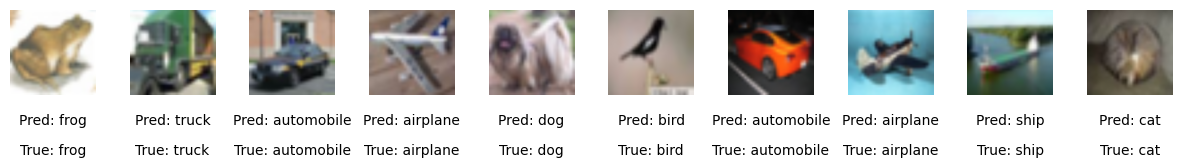

In [13]:
# Visualization
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = tf.image.resize(x_test[idx], IMAGE_SIZE).numpy()
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis('off')
    ax.text(
        0.5, -0.35,
        f"Pred: {predicted_classes[idx]}",
        fontsize=10,
        ha="center",
        transform=ax.transAxes
    )
    ax.text(
        0.5, -0.7,
        f"True: {actual_classes[idx]}",
        fontsize=10,
        ha="center",
        transform=ax.transAxes
    )
    ax.imshow(img)
plt.show()